# Datenanalyse

Import Libraries

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import spacy

%matplotlib inline

In [ ]:
!python -m spacy download de

## Laden des Datensatzes
Alternativ kann der Datensatz aus der result.csv direkt eingeladen werden, ohne URL

In [4]:
url = 'https://drive.google.com/file/d/1ru8qY3_OoyTbebCX68-WreAlvuqy5A2a/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path)

In [5]:
data

,title,origin,is_question,has_slang,has_number,avg_word_length,class_name,label
0,„Bauer sucht Frau“-Quiz,promi,0,1,0,6,light,0
1,Die 10 besten Apps für Mädchen,bravo,0,1,1,4,hard,0
2,Carmen Geiss hat eine neue Frisur und die Fans...,webde,0,1,0,4,hard,0
3,Studentenstreik in Thüringen,wiki,0,0,0,8,no_bait,1
4,Ilmenau: UniCopy ist umgezogen,wiki,0,0,0,6,no_bait,1
...,...,...,...,...,...,...,...,...
19995,Sind Luca Hänni und „Let's Dance“-Christina Lu...,promi,1,0,0,5,medium,0
19996,Opposition: Parlament muss über Tornado-Einsat...,wiki,0,0,0,8,no_bait,1
19997,Daimler trennt sich von Chrysler,wiki,0,0,0,5,no_bait,1
19998,Deutsches Bundesverfassungsgericht: „Hartz IV“...,wiki,0,0,0,12,no_bait,1


In [6]:
clickbaits=data[data.label==0].copy()
clickbaits.describe()

,is_question,has_slang,has_number,avg_word_length,label
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0
mean,0.334400,0.609000,0.132200,5.197100,0.0
std,0.471804,0.487999,0.338725,1.170978,0.0
min,0.000000,0.000000,0.000000,1.000000,0.0
25%,0.000000,0.000000,0.000000,4.000000,0.0
50%,0.000000,1.000000,0.000000,5.000000,0.0
75%,1.000000,1.000000,0.000000,6.000000,0.0
max,1.000000,1.000000,1.000000,25.000000,0.0


In [7]:
non=data[data.label==1].copy()
non.describe()

,is_question,has_slang,has_number,avg_word_length,label
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.0
mean,0.022000,0.029000,0.038700,7.064300,1.0
std,0.146691,0.167815,0.192889,1.809943,0.0
min,0.000000,0.000000,0.000000,3.000000,1.0
25%,0.000000,0.000000,0.000000,6.000000,1.0
50%,0.000000,0.000000,0.000000,7.000000,1.0
75%,0.000000,0.000000,0.000000,8.000000,1.0
max,1.000000,1.000000,1.000000,27.000000,1.0


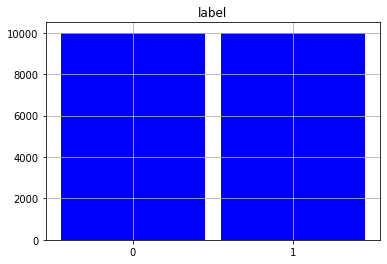

In [8]:
data[['label']].hist(bins = 3)
plt.bar(np.arange(len([0,1])), data.groupby(['label']).size().values, 0.9,  color="blue")
plt.xticks(np.arange(len([0,1])), [0,1])
plt.show()

In [9]:
datagr = data.copy()
del datagr["is_question"]
del datagr["class_name"]
del datagr["origin"]
del datagr["has_number"]
del datagr["label"]
del datagr["avg_word_length"]

## Anteile je Quelle

In [10]:
group_data = data.groupby("origin").agg("count")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2302fc2208>],
      dtype=object)

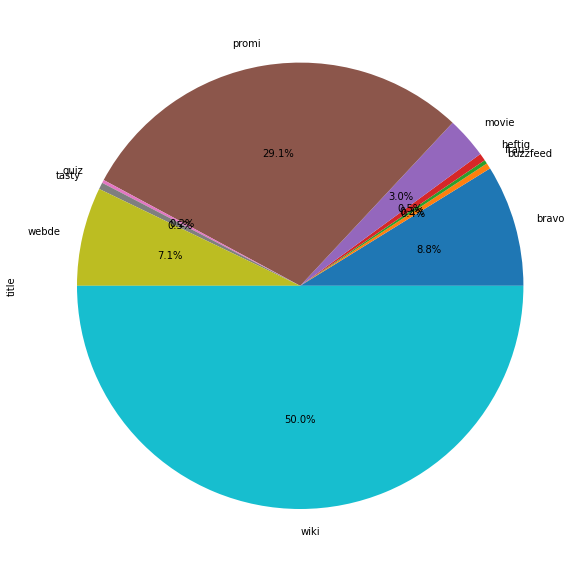

In [11]:
group_data["title"].plot.pie(subplots=True,figsize=(10, 16),autopct='%1.1f%%')

## Datenanalyse

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2302a01320>,
      dtype=object)

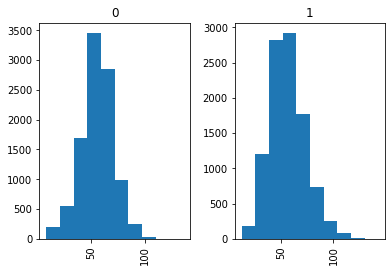

In [12]:
data['title'].str.len().hist(by=data['label'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2301c51278>,
      dtype=object)

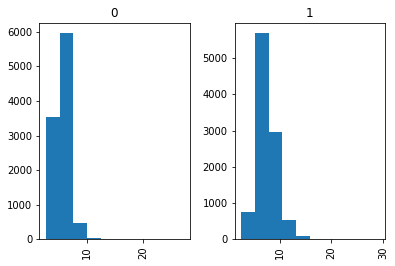

In [14]:
data['title'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=data['label'])

Make Copy of clickbaits and non-clickbaits

In [15]:
clickbaits=data[data.label==0].copy()
not_clickbaits=data[data.label==1].copy()

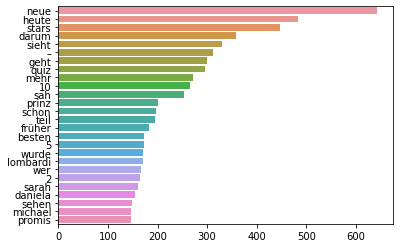

In [16]:
stop=set(stopwords.words('german'))
clickbaits['title'] = clickbaits['title'].str.lower()
clickbaits['title'] = clickbaits.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = clickbaits['title'].str.split()
new=new.values.tolist()
corpus_title_clickbait=[word for i in new for word in i]

counter=Counter(corpus_title_clickbait)
most=counter.most_common()
x, y= [], []
for word,count in most[:70]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [17]:
print(x)

['neue', 'heute', 'stars', 'darum', 'sieht', '–', 'geht', 'quiz', 'mehr', '10', 'sah', 'prinz', 'schon', 'teil', 'früher', 'besten', '5', 'wurde', 'lombardi', 'wer', '2', 'sarah', 'daniela', 'sehen', 'michael', 'promis']


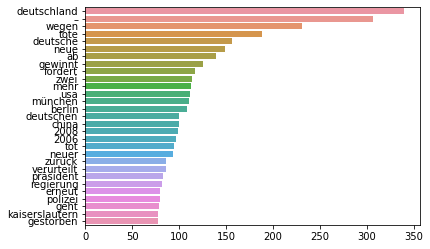

In [18]:
stop=set(stopwords.words('german'))
not_clickbaits['title'] = not_clickbaits['title'].str.lower()
not_clickbaits['title'] = not_clickbaits.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
new = not_clickbaits['title'].str.split()
new=new.values.tolist()
corpus_title_non_clickbait=[word for i in new for word in i]

counter=Counter(corpus_title_non_clickbait)
most=counter.most_common()
x, y= [], []
for word,count in most[:70]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [19]:
# Ngram analysis function

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

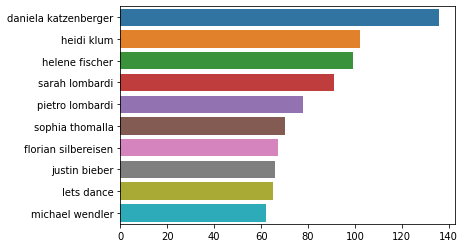

In [20]:
clickbaits['title'] = clickbaits['title'].str.lower()
clickbaits['title'] = clickbaits.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
clickbaits['title'] = clickbaits['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(clickbaits['title'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

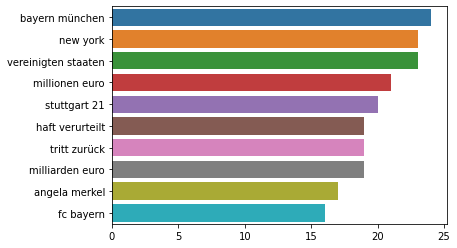

In [21]:
not_clickbaits['title'] = not_clickbaits['title'].str.lower()
not_clickbaits['title'] = not_clickbaits.title.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
not_clickbaits['title'] = not_clickbaits['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

top_n_bigrams=get_top_ngram(not_clickbaits['title'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

In [22]:
def preprocess_news(df,column):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df[column]:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

In [25]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

In [26]:
clickbait_text = [word for word in clickbaits['title']]
non_clickbait_text = [word for word in not_clickbaits['title']]

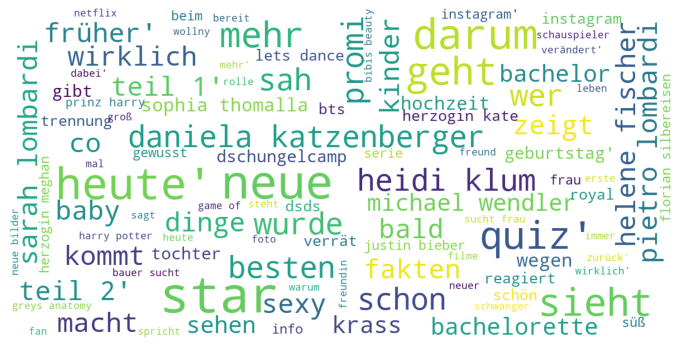

In [27]:
show_wordcloud(clickbait_text)

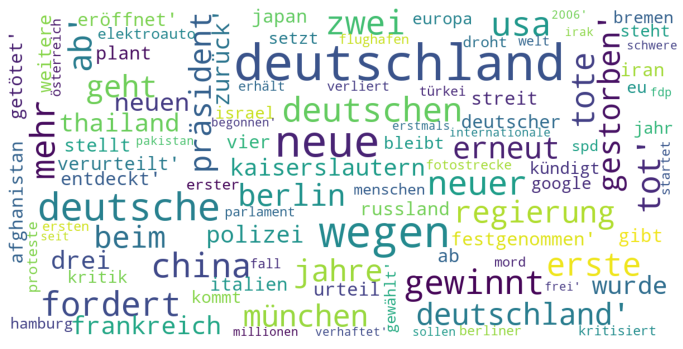

In [28]:
show_wordcloud(non_clickbait_text)

In [29]:
clickbaits["title"]

0                                  „bauer sucht frau“quiz
1                                  10 besten apps mädchen
2            carmen geiss neue frisur fans finden grausam
5                             top 6 schönsten wiedersehen
9           jochen schropp freund bekannt spricht partner
                               ...                       
19991                schon groß angelina jolie zeigt kids
19992     besten bilder prinzessin charlotte geburt heute
19994           top 17 besten schauspieler filmgeschichte
19995     luca hänni „lets dance“christina luft etwa paar
19999    gewusst andrea kiewel begann karriere sportlerin
Name: title, Length: 10000, dtype: object

## POS-tagging

In [31]:
nlp = spacy.load('de')

In [32]:
def make_pos(df, common):
    nouns = []
    adjectives = []
    verbs = []
    conjunctions = []
    pronouns = []
    preposition = []
    adverbs = []
    return_dict = dict()

    for title in df:
        for token in nlp(title):
            if token.pos_ == "NOUN":
                nouns.append(token)
            if token.pos_ == "ADJ":
                adjectives.append(token)
            if token.pos_ == "VERB":
                verbs.append(token)
            if token.pos_ == "ADP":
                conjunctions.append(token)
            if token.pos_ == "PRON":
                pronouns.append(token)
            if token.pos_ == "PROPN":
                preposition.append(token)
            if token.pos_ == "ADV":
                adverbs.append(token)
    
    job_list = [nouns, adjectives, verbs, conjunctions, pronouns, preposition, adverbs]
    jobs = {"nouns": nouns, "adjectives": adjectives, "verbs": verbs, "conjunctions": conjunctions, "pronouns": pronouns, "preposition": preposition, "adverbs": adverbs}

    for key, value in jobs.items():
        lemmas_job = [x.lemma_ for x in value]
        freq_job = Counter(lemmas_job)
        return_dict.update({key:{"freq_words": freq_job.most_common(common), "sum": len(freq_job)}})


    return return_dict

In [33]:
data = make_pos(clickbaits["title"], 20)

In [34]:
data2 = make_pos(not_clickbaits["title"], 20)

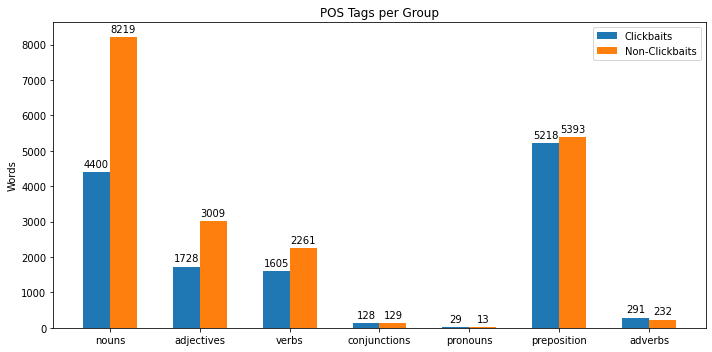

In [35]:
keys = list(data.keys())
labels = []
sums = []
for key in keys:
    labels.append(key)
    sums.append(data[key]["sum"])


keys2 = list(data2.keys())
sums2 = []
for key2 in keys2:
    sums2.append(data2[key2]["sum"])


x = np.arange(len(labels))  
width = 0.3

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, sums, width, label='Clickbaits', align="center")
rects2 = ax.bar(x + width/2, sums2, width, label='Non-Clickbaits', align="center")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Words')
ax.set_title('POS Tags per Group')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()